<a href="https://colab.research.google.com/github/fedhere/PUS2020_KLee/blob/master/HW8/revised_HW8_RandomForest_instructions_Kyungmin.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Following the paper "Examining the feasibility of using open data to benchmark building energy usage in cities: A data science and policy perspective" [Roth et al 2019](https://www.researchgate.net/publication/337074109_Examining_the_feasibility_of_using_open_data_to_benchmark_building_energy_usage_in_cities_A_data_science_and_policy_perspective), choose 2 cities in the dataset available through the paper's github repository https://github.com/Urban-Informatics-Lab/Open-Data-Benchmarking

This paper is an excellent example of reproducible research. 

I also created an example of using random forest classifier and regressors here https://github.com/fedhere/PUS2020_FBianco/blob/master/classdemos/COVID19LOS_featureExtractionRFexample.ipynb and there are links at the bottom of this notebook to useful functions and examples on the internet of applications of methods you will need to use.

1. Read the introduction to the paper and describe here (briefly) the goals of their analysis (and the analysis that you are about to reproduce). Max 200 words.
2. Choose 2 cities (any 2 cities except Seattle cause I am running some of the Seattle analysis below for guidance)
3. For each of the 2 cities reproduce their analysis by 

  3.1 gathering the original data from their repository (see below for Seattle example)

  3.2 clean the data according to their data preparation scheme, including one-hot-encoding categorical variables, except to impute missing data using KNearestNeighors instead of Gibbs sampling (see below)

  3.3 run a Random Forest (RF) Regressor to predict the total energy consumption.

  3.4 evaluate the RF model performance by printing the R2 score (the default score in SKLearn RF) for training and test set (discuss)

  3.5 plot the features sorted by their importance and identify the most important features. are they consistent between the 2 cities? are they consistent with the paper's result?
4 compare the result for the 2 cities (discuss)

5. Extra credit: 

  5.1 modify the target variable to a binary variable choosing the median of the variable values as the the energy threshold and predict whether the value is higher or lower than the threshold
  5.2 Run a Random Forest Classifier to predict if an observation is in the upper 50% percentile or lower 50% percentile (above or below the median threshold)
  5.3 Measure the performance of the model on training and test data
  5.4 Measure the feature importance and assess if the important feature have changed (discuss)

# Goals of the analysis

Roth et al. (2020) examines the feasibility of using city-specific public open data sources to benchmark building energy usage in cities in term of a data science and policy perspective. The goal of this study is to compare the results of the two bechmarking models, which is used to evaluate the process of measuring building energy performance to identify inefficient buildings. the research qeustions are followings: 

* Can city wide energy benchmarking be conducted using only open data and how do such models compare to the current practice?
* What benchmarking data fields are important for cities to collect?
* What policies and programs can cities adopt to enhance the efficacy of their energy benchmarking programs?

By using random forest and lasso regression, this study finds out the performance difference between linear and non-linear models. It also identified the most important avariables as building area, property type, conditioned area, and water usage.  

**Reference** 

Roth, Jonathan, Benjamin Lim, Rishee K. Jain, and Dian Grueneich. "Examining the feasibility of using open data to benchmark building energy usage in cities: A data science and policy perspective." Energy Policy 139 (2020): 111327.


# choose a city and read in the data

In [ ]:
import pandas as pd
import numpy as np

In [ ]:
london = pd.read_csv("https://raw.githubusercontent.com/Urban-Informatics-Lab/Open-Data-Benchmarking/master/London/london_final.csv")
london.head()

,Unnamed: 0,rrn,post_town,county,zip,energy_rating_band,energy_rating,total_CO2_emissions_MT,heating_fuel_type,hvac_type,floor_area_M2,fuel_eui_KWHM2,electricity_eui_KWHM2,typical_fuel_eui_KWHM2,typical_electricity_eui_KWHM2,renewables_percent_thermal,renewables_percent_electrical,total_heat_energy_KWH,total_electricity_KWH,total_heat_energy_typical_KWH,total_electricity_typical_KWH,floor_area_SF,total_site_energy_KBTU,log_total_site_energy_KBTU,site_eui_KBTUSF
0,1,0793-0110-4549-4309-1096,LONDON,Greater London Authority,9729,D,89,99,Natural Gas,Heating and Mechanical Ventilation,1241.0,113,106,237,80,0.0,0.0,140233.0,131546.0,294117.0,99280.0,13357.99990,9.273480e+05,13.740084,69.422668
1,2,9090-1984-0130-1780-7004,GREENFORD,Greater London Authority,16964,E,102,191,Natural Gas,Heating and Natural Ventilation,2512.0,178,75,225,56,0.0,0.0,447136.0,188400.0,565200.0,140672.0,27038.91680,2.168538e+06,14.589564,80.200617
2,3,9770-1059-0907-0690-7901,CROYDON,Greater London Authority,3321,D,77,99,Natural Gas,Heating and Natural Ventilation,1555.0,195,47,251,62,0.0,0.0,303225.0,73085.0,390305.0,96410.0,16737.86450,1.284022e+06,14.065508,76.713634
3,4,0770-0210-5879-1709-4096,CROYDON,Greater London Authority,3320,F,143,95,Natural Gas,Heating and Natural Ventilation,1302.8,225,53,148,40,0.0,0.0,293130.0,69048.4,192814.4,52112.0,14023.20892,1.235803e+06,14.027232,88.125579
4,5,0166-1060-0216-0290-5501,CROYDON,Greater London Authority,3381,E,106,67,Natural Gas,Air Conditioning,1097.0,103,75,42,91,0.0,0.0,112991.0,82275.0,46074.0,99827.0,11807.99830,6.662749e+05,13.409458,56.425730


In [ ]:
dc = pd.read_csv("https://raw.githubusercontent.com/Urban-Informatics-Lab/Open-Data-Benchmarking/master/DC/DC_final.csv")
dc.head()

,Unnamed: 0,report_status,ward,postal_code,year_built,primary_ptype_self,primary_ptype_epa,tax_record_floor_area,reported_gross_floor_area,water_use,metered_areas_energy,metered_areas_water,electricity_use,natural_gas_use,energy_star_score,site_eui,weather_norm_site_eui,source_eui,weather_norm_source_eui,total_ghg_emissions,total_ghg_emissions_intensity,total_site_energy_KBTU,log_total_site_energy_KBTU
0,1,In Compliance,4,20011,1959,Multifamily Housing,Multifamily Housing,63227.0,65000.0,6963.5,Whole Building,Whole Building,633043.8,44274.18307,9.0,101.3,102.7,175.9,174.9,482.9,7.4,6584500.0,15.700229
1,2,In Compliance,2,20005,1997,Office,Office,251557.0,257943.0,8490.0,Whole Building,Whole Building,5531486.0,NaN,69.0,73.2,73.2,229.8,229.8,2164.4,8.4,18881427.6,16.753689
2,3,In Compliance,2,20036,1964,Office,Office,330550.0,223218.0,8749.1,Whole Building,Whole Building,3863003.0,64143.38666,76.0,87.8,89.0,215.6,215.0,1852.2,8.3,19598540.4,16.790966
3,4,In Compliance,2,22202,1969,Office,Office,256839.0,213067.0,5393.8,Whole Building,Whole Building,2936445.0,NaN,87.0,47.0,46.4,147.7,145.8,1249.2,5.9,10014149.0,16.119510
4,5,In Compliance,2,20037,1975,Office,Office,370000.0,381518.0,10422.6,Whole Building,Whole Building,7345290.0,NaN,85.0,65.7,65.7,206.3,206.3,2874.1,7.5,25065732.6,17.037012


# inspect the dataframe

In [ ]:
london.describe()

,Unnamed: 0,zip,energy_rating,total_CO2_emissions_MT,floor_area_M2,fuel_eui_KWHM2,electricity_eui_KWHM2,typical_fuel_eui_KWHM2,typical_electricity_eui_KWHM2,renewables_percent_thermal,renewables_percent_electrical,total_heat_energy_KWH,total_electricity_KWH,total_heat_energy_typical_KWH,total_electricity_typical_KWH,floor_area_SF,total_site_energy_KBTU,log_total_site_energy_KBTU,site_eui_KBTUSF
count,23474.000000,23474.000000,23474.000000,23474.000000,23474.000000,23474.000000,23474.00000,23474.000000,23474.000000,23474.000000,23474.000000,2.347400e+04,2.347400e+04,2.347400e+04,2.347400e+04,2.347400e+04,2.347400e+04,23474.000000,23474.000000
mean,11737.500000,9271.378887,134.872966,304.372029,3448.422946,169.854861,76.29390,212.057638,65.405129,0.157949,0.424793,6.236950e+05,3.293685e+05,8.143107e+05,2.552551e+05,3.711848e+04,3.251986e+06,14.360666,78.028784
std,6776.504446,5320.827711,581.743761,882.967259,6432.287065,100.733843,55.41504,116.658846,33.401942,2.498934,4.355098,1.913214e+06,1.010481e+06,2.398929e+06,6.078081e+05,6.923649e+04,9.391810e+06,0.947959,39.438203
min,1.000000,1.000000,-1.000000,0.000000,1.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.076390e+01,1.269316e+03,7.146234,1.267994
25%,5869.250000,4663.250000,77.000000,78.000000,1322.000000,108.000000,42.00000,154.000000,40.000000,0.000000,0.000000,1.820040e+05,6.684000e+04,2.229379e+05,6.455020e+04,1.422988e+04,9.038492e+05,13.714418,52.304750
50%,11737.500000,9286.500000,95.000000,127.000000,1907.000000,146.000000,58.00000,165.000000,50.000000,0.000000,0.000000,2.990530e+05,1.156260e+05,3.630060e+05,1.106326e+05,2.052676e+04,1.468815e+06,14.199966,66.252684
75%,17605.750000,13841.750000,116.000000,261.000000,3379.750000,203.000000,92.00000,234.000000,83.000000,0.000000,0.000000,5.754570e+05,2.723235e+05,7.364308e+05,2.431839e+05,3.637929e+04,2.883832e+06,14.874630,91.612562
max,23474.000000,18480.000000,9999.000000,34439.000000,280912.000000,746.000000,725.00000,1455.000000,337.000000,90.300000,100.000000,9.905038e+07,3.334334e+07,1.123648e+08,2.556299e+07,3.023709e+06,4.322920e+08,19.884612,256.451775


In [ ]:
dc.describe()

,Unnamed: 0,ward,year_built,tax_record_floor_area,reported_gross_floor_area,water_use,electricity_use,natural_gas_use,energy_star_score,site_eui,weather_norm_site_eui,source_eui,weather_norm_source_eui,total_ghg_emissions,total_ghg_emissions_intensity,total_site_energy_KBTU,log_total_site_energy_KBTU
count,1455.000000,1455.000000,1455.000000,1.455000e+03,1.455000e+03,1.455000e+03,1.441000e+03,1.054000e+03,1184.000000,1455.000000,1393.000000,1455.000000,1393.000000,1454.000000,1454.000000,1.455000e+03,1455.000000
mean,793.997938,3.472852,1940.804811,2.046748e+05,1.897612e+05,5.109905e+04,2.760114e+06,5.853217e+04,62.090372,69.960206,70.745154,171.274433,171.302872,1318.734388,6.674278,1.344870e+07,15.905810
std,469.582655,2.047691,167.230361,2.451302e+05,2.436786e+05,6.163321e+05,4.599984e+06,2.617060e+05,26.792483,30.676317,31.476591,76.707287,76.884877,2458.471157,3.143349,2.843799e+07,0.991320
min,1.000000,1.000000,1000.000000,9.171000e+03,9.171000e+03,0.000000e+00,1.785000e+02,0.000000e+00,1.000000,1.100000,1.100000,1.200000,1.200000,3.100000,0.100000,5.729350e+04,10.955942
25%,380.500000,2.000000,1947.000000,7.164000e+04,7.111750e+04,1.958050e+03,7.435930e+05,1.121760e+04,43.750000,51.600000,51.900000,121.850000,121.600000,400.450000,4.800000,4.513227e+06,15.322523
50%,794.000000,2.000000,1971.000000,1.287720e+05,1.215530e+05,4.063800e+03,1.612028e+06,2.770698e+04,70.000000,65.900000,66.600000,163.300000,163.400000,757.100000,6.300000,8.156027e+06,15.914268
75%,1176.500000,5.000000,1994.000000,2.585310e+05,2.372130e+05,7.008700e+03,3.386553e+06,5.154631e+04,84.000000,82.850000,84.500000,206.450000,207.400000,1534.450000,7.800000,1.565570e+07,16.566343
max,2181.000000,8.000000,2017.000000,3.997572e+06,5.634890e+06,1.929391e+07,1.207430e+08,7.269109e+06,100.000000,213.600000,215.500000,618.600000,620.600000,64992.500000,30.600000,7.832497e+08,20.478962


# Clean the data 
follow closely the second paragraph of Section 4 DATA. Name each step you do accordingly to the description in the paragraf
https://www.researchgate.net/publication/337074109_Examining_the_feasibility_of_using_open_data_to_benchmark_building_energy_usage_in_cities_A_data_science_and_policy_perspective 

you can also help yourself inspecting the final datasets posted on the github repo but name each action according to the paper narrative: for example, if you drop "Building ID" indicate that this is done as part of 
_We then cleaned the datasets by removing irrelevant building-identifying features (such as
address)_, or if dropping a variable with too many missing values _removing features that had missing values for greater than 40% of the buildings in the dataset._

In [ ]:
# London
# summarize the number of rows with missing values for each column
for c in london.columns:
  
  # count number of rows with missing values
  n_miss = london[c].isnull().sum()
  perc = n_miss / london.shape[0] * 100
  print('%s (%s):  Missing: %d (%.1f%%)' % (c, london[c].dtype, 
                                                  n_miss, perc))

Unnamed: 0 (int64):  Missing: 0 (0.0%)
rrn (object):  Missing: 0 (0.0%)
post_town (object):  Missing: 0 (0.0%)
county (object):  Missing: 26 (0.1%)
zip (int64):  Missing: 0 (0.0%)
energy_rating_band (object):  Missing: 0 (0.0%)
energy_rating (int64):  Missing: 0 (0.0%)
total_CO2_emissions_MT (int64):  Missing: 0 (0.0%)
heating_fuel_type (object):  Missing: 1 (0.0%)
hvac_type (object):  Missing: 0 (0.0%)
floor_area_M2 (float64):  Missing: 0 (0.0%)
fuel_eui_KWHM2 (int64):  Missing: 0 (0.0%)
electricity_eui_KWHM2 (int64):  Missing: 0 (0.0%)
typical_fuel_eui_KWHM2 (int64):  Missing: 0 (0.0%)
typical_electricity_eui_KWHM2 (int64):  Missing: 0 (0.0%)
renewables_percent_thermal (float64):  Missing: 0 (0.0%)
renewables_percent_electrical (float64):  Missing: 0 (0.0%)
total_heat_energy_KWH (float64):  Missing: 0 (0.0%)
total_electricity_KWH (float64):  Missing: 0 (0.0%)
total_heat_energy_typical_KWH (float64):  Missing: 0 (0.0%)
total_electricity_typical_KWH (float64):  Missing: 0 (0.0%)
floor_

In [ ]:
# DC
# summarize the number of rows with missing values for each column
for c in dc.columns:
  
  # count number of rows with missing values
  n_miss = dc[c].isnull().sum()
  perc = n_miss / dc.shape[0] * 100
  print('%s (%s):  Missing: %d (%.1f%%)' % (c, dc[c].dtype, 
                                                  n_miss, perc))

Unnamed: 0 (int64):  Missing: 0 (0.0%)
report_status (object):  Missing: 0 (0.0%)
ward (int64):  Missing: 0 (0.0%)
postal_code (object):  Missing: 0 (0.0%)
year_built (int64):  Missing: 0 (0.0%)
primary_ptype_self (object):  Missing: 0 (0.0%)
primary_ptype_epa (object):  Missing: 0 (0.0%)
tax_record_floor_area (float64):  Missing: 0 (0.0%)
reported_gross_floor_area (float64):  Missing: 0 (0.0%)
water_use (float64):  Missing: 0 (0.0%)
metered_areas_energy (object):  Missing: 0 (0.0%)
metered_areas_water (object):  Missing: 0 (0.0%)
electricity_use (float64):  Missing: 14 (1.0%)
natural_gas_use (float64):  Missing: 401 (27.6%)
energy_star_score (float64):  Missing: 271 (18.6%)
site_eui (float64):  Missing: 0 (0.0%)
weather_norm_site_eui (float64):  Missing: 62 (4.3%)
source_eui (float64):  Missing: 0 (0.0%)
weather_norm_source_eui (float64):  Missing: 62 (4.3%)
total_ghg_emissions (float64):  Missing: 1 (0.1%)
total_ghg_emissions_intensity (float64):  Missing: 1 (0.1%)
total_site_energy_

# FBB it would have been nice if you commented on this output

# transform input features as needed



for example replace features with log features. Guide yourself with the text, the final dataset names, and also the code here https://github.com/Urban-Informatics-Lab/Open-Data-Benchmarking/blob/master/Lasso_RandomForest.Rmd

In [ ]:
london.describe()

,Unnamed: 0,zip,energy_rating,total_CO2_emissions_MT,floor_area_M2,fuel_eui_KWHM2,electricity_eui_KWHM2,typical_fuel_eui_KWHM2,typical_electricity_eui_KWHM2,renewables_percent_thermal,renewables_percent_electrical,total_heat_energy_KWH,total_electricity_KWH,total_heat_energy_typical_KWH,total_electricity_typical_KWH,floor_area_SF,total_site_energy_KBTU,log_total_site_energy_KBTU,site_eui_KBTUSF
count,23474.000000,23474.000000,23474.000000,23474.000000,23474.000000,23474.000000,23474.00000,23474.000000,23474.000000,23474.000000,23474.000000,2.347400e+04,2.347400e+04,2.347400e+04,2.347400e+04,2.347400e+04,2.347400e+04,23474.000000,23474.000000
mean,11737.500000,9271.378887,134.872966,304.372029,3448.422946,169.854861,76.29390,212.057638,65.405129,0.157949,0.424793,6.236950e+05,3.293685e+05,8.143107e+05,2.552551e+05,3.711848e+04,3.251986e+06,14.360666,78.028784
std,6776.504446,5320.827711,581.743761,882.967259,6432.287065,100.733843,55.41504,116.658846,33.401942,2.498934,4.355098,1.913214e+06,1.010481e+06,2.398929e+06,6.078081e+05,6.923649e+04,9.391810e+06,0.947959,39.438203
min,1.000000,1.000000,-1.000000,0.000000,1.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.076390e+01,1.269316e+03,7.146234,1.267994
25%,5869.250000,4663.250000,77.000000,78.000000,1322.000000,108.000000,42.00000,154.000000,40.000000,0.000000,0.000000,1.820040e+05,6.684000e+04,2.229379e+05,6.455020e+04,1.422988e+04,9.038492e+05,13.714418,52.304750
50%,11737.500000,9286.500000,95.000000,127.000000,1907.000000,146.000000,58.00000,165.000000,50.000000,0.000000,0.000000,2.990530e+05,1.156260e+05,3.630060e+05,1.106326e+05,2.052676e+04,1.468815e+06,14.199966,66.252684
75%,17605.750000,13841.750000,116.000000,261.000000,3379.750000,203.000000,92.00000,234.000000,83.000000,0.000000,0.000000,5.754570e+05,2.723235e+05,7.364308e+05,2.431839e+05,3.637929e+04,2.883832e+06,14.874630,91.612562
max,23474.000000,18480.000000,9999.000000,34439.000000,280912.000000,746.000000,725.00000,1455.000000,337.000000,90.300000,100.000000,9.905038e+07,3.334334e+07,1.123648e+08,2.556299e+07,3.023709e+06,4.322920e+08,19.884612,256.451775


In [ ]:
dc.describe()

,Unnamed: 0,ward,year_built,tax_record_floor_area,reported_gross_floor_area,water_use,electricity_use,natural_gas_use,energy_star_score,site_eui,weather_norm_site_eui,source_eui,weather_norm_source_eui,total_ghg_emissions,total_ghg_emissions_intensity,total_site_energy_KBTU,log_total_site_energy_KBTU
count,1455.000000,1455.000000,1455.000000,1.455000e+03,1.455000e+03,1.455000e+03,1.441000e+03,1.054000e+03,1184.000000,1455.000000,1393.000000,1455.000000,1393.000000,1454.000000,1454.000000,1.455000e+03,1455.000000
mean,793.997938,3.472852,1940.804811,2.046748e+05,1.897612e+05,5.109905e+04,2.760114e+06,5.853217e+04,62.090372,69.960206,70.745154,171.274433,171.302872,1318.734388,6.674278,1.344870e+07,15.905810
std,469.582655,2.047691,167.230361,2.451302e+05,2.436786e+05,6.163321e+05,4.599984e+06,2.617060e+05,26.792483,30.676317,31.476591,76.707287,76.884877,2458.471157,3.143349,2.843799e+07,0.991320
min,1.000000,1.000000,1000.000000,9.171000e+03,9.171000e+03,0.000000e+00,1.785000e+02,0.000000e+00,1.000000,1.100000,1.100000,1.200000,1.200000,3.100000,0.100000,5.729350e+04,10.955942
25%,380.500000,2.000000,1947.000000,7.164000e+04,7.111750e+04,1.958050e+03,7.435930e+05,1.121760e+04,43.750000,51.600000,51.900000,121.850000,121.600000,400.450000,4.800000,4.513227e+06,15.322523
50%,794.000000,2.000000,1971.000000,1.287720e+05,1.215530e+05,4.063800e+03,1.612028e+06,2.770698e+04,70.000000,65.900000,66.600000,163.300000,163.400000,757.100000,6.300000,8.156027e+06,15.914268
75%,1176.500000,5.000000,1994.000000,2.585310e+05,2.372130e+05,7.008700e+03,3.386553e+06,5.154631e+04,84.000000,82.850000,84.500000,206.450000,207.400000,1534.450000,7.800000,1.565570e+07,16.566343
max,2181.000000,8.000000,2017.000000,3.997572e+06,5.634890e+06,1.929391e+07,1.207430e+08,7.269109e+06,100.000000,213.600000,215.500000,618.600000,620.600000,64992.500000,30.600000,7.832497e+08,20.478962


check what happened to missing values, fix infinities replacing them with 0 as done in https://github.com/Urban-Informatics-Lab/Open-Data-Benchmarking/blob/master/Lasso_RandomForest.Rmd

In [ ]:
# London

# Find "0" values
london[london["typical_fuel_eui_KWHM2"] == 0]
london[london["typical_electricity_eui_KWHM2"] == 0]

# Erase "0"rows
london = london[london["typical_fuel_eui_KWHM2"] != 0]
london = london[london["typical_electricity_eui_KWHM2"] != 0]

# Set freatures  
# Reference: https://github.com/Urban-Informatics-Lab/Open-Data-Benchmarking/blob/master/Lasso_RandomForest.Rmd
lcols = ["heating_fuel_type","hvac_type","typical_fuel_eui_KWHM2","typical_electricity_eui_KWHM2","floor_area_SF"]
london_features = london[lcols]
london_features

# Check number of rows, number of columns
print(london_features.shape)

# Add log values in the columns
london_features["log_typical_fuel_eui_KWHM2"] = np.log10(london_features["typical_fuel_eui_KWHM2"])
london_features["log_typical_electricity_eui_KWHM2"] = np.log10(london_features["typical_electricity_eui_KWHM2"])
london_features["log_floor_area_SF"] = np.log10(london_features["floor_area_SF"])

(23153, 5)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stab

In [ ]:
# DC

# Find "0" values
dc[dc["water_use"] == 0]

# Erase "0"rows
dc = dc[dc["water_use"] != 0]

# Set freatures  
# Reference: https://github.com/Urban-Informatics-Lab/Open-Data-Benchmarking/blob/master/Lasso_RandomForest.Rmd
dcols = ["report_status","ward","postal_code","year_built","primary_ptype_self","primary_ptype_epa","tax_record_floor_area","reported_gross_floor_area","water_use","metered_areas_energy","metered_areas_water"]
DC_features = dc[dcols]
DC_features

# Check number of rows, number of columns
print(DC_features.shape)

# Add log values in the columns
DC_features["log_tax_record_floor_area"] = np.log10(DC_features["tax_record_floor_area"])
DC_features["log_reported_gross_floor_area"] = np.log10(DC_features["reported_gross_floor_area"])
DC_features["log_water_use"] = np.log10(DC_features["water_use"])

(1453, 11)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stab

# FBB what happened to the missing values? did you have any? did they have to be replaced? did the log transformation cause more missing values? ... i did ask to "check it"

# separate categorical and numerical values
you will proceed to missing data imputation differently in the 2 cases

In [ ]:
# London

# Separate dataframes to categorical and numerical datavalues 
london_features_cat = london_features[["heating_fuel_type","hvac_type"]].fillna("None") #categorical values: 2
london_features_num = london_features[["typical_fuel_eui_KWHM2",
                                       "typical_electricity_eui_KWHM2","floor_area_SF"]] # numerical values : 3

# Set Y values 
london_y = london["log_total_site_energy_KBTU"]
print(pd.qcut(london_y, [0, .25, .5, .75, 1.]).astype('category'))

0          (13.713, 14.2]
1          (14.2, 14.879]
2          (13.713, 14.2]
3          (13.713, 14.2]
4         (7.145, 13.713]
               ...       
23469      (14.2, 14.879]
23470      (13.713, 14.2]
23471      (14.2, 14.879]
23472    (14.879, 19.885]
23473    (14.879, 19.885]
Name: log_total_site_energy_KBTU, Length: 23153, dtype: category
Categories (4, interval[float64]): [(7.145, 13.713] < (13.713, 14.2] < (14.2, 14.879] <
                                    (14.879, 19.885]]


In [ ]:
# DC

# Separate dataframes to categorical and numerical datavalues 
DC_features_cat = DC_features[["report_status","ward","postal_code","year_built",
                               "primary_ptype_self","primary_ptype_epa","metered_areas_energy",
                               "metered_areas_water"]].fillna("None") #categorical values: 8
DC_features_num = DC_features[["log_tax_record_floor_area", "log_reported_gross_floor_area", 
                               "log_water_use"]] # numerical values : 3

# Set Y values 
dc["log_total_site_energy_KBTU"] = np.log10(dc["total_site_energy_KBTU"]).values
DC_y = dc["log_total_site_energy_KBTU"]
print(pd.qcut(DC_y, [0, .25, .5, .75, 1.]).astype('category'))

0       (6.655, 6.913]
1       (7.196, 8.894]
2       (7.196, 8.894]
3       (6.913, 7.196]
4       (7.196, 8.894]
             ...      
1450    (4.757, 6.655]
1451    (6.655, 6.913]
1452    (6.913, 7.196]
1453    (4.757, 6.655]
1454    (4.757, 6.655]
Name: log_total_site_energy_KBTU, Length: 1453, dtype: category
Categories (4, interval[float64]): [(4.757, 6.655] < (6.655, 6.913] < (6.913, 7.196] < (7.196, 8.894]]


# use Nearest Neighbor Imputer to impute missing values in numerical features

here we are deviating from the paper. NN imputation is simpler and more common, I think it may be more useful to you in general

In [ ]:
from sklearn.impute import KNNImputer

# define imputer
imputer = KNNImputer(n_neighbors=5, weights='uniform', metric='nan_euclidean')

In [ ]:
# London

# fit on the dataset
london_features_num = london_features_num.astype(float).replace([np.inf, -np.inf], np.nan).dropna()
imputer.fit(london_features_num)
# transform the dataset
imputer.transform(london_features_num)
london_X1 = imputer.transform(london_features_num)
london_X1.shape

(23153, 3)

In [ ]:
# DC

# fit on the dataset
DC_features_num = DC_features_num.astype(float).replace([np.inf, -np.inf], np.nan).dropna()
imputer.fit(DC_features_num)
# transform the dataset
imputer.transform(DC_features_num)
DC_X1 = imputer.transform(DC_features_num)
DC_X1.shape

(1453, 3)

# convert categorical variables to one-hot-encoded 
you will have to remove Nan values and replace them. You can choose to replace them with "None" or a similar string, for which you can use the fillna method: ```df.fillna("None")``` and leave it at that or with a little more effort you can input values based on nearest neighbors or some other inputation scheme. any choice goes so long as it is well described and justified with words.

In [ ]:
from sklearn.preprocessing import OneHotEncoder

In [ ]:
# London
london[["heating_fuel_type","hvac_type","typical_fuel_eui_KWHM2","typical_electricity_eui_KWHM2","floor_area_SF"]].fillna("None")

london_features_cat = london_features[["heating_fuel_type","hvac_type"]].fillna("None")

london_enc = OneHotEncoder(handle_unknown='ignore')
london_enc.fit(london_features_cat)
london_X2 = london_enc.transform(london_features_cat).toarray()
print(london_X2.shape)
london_enc.categories_

(23153, 18)


[array(['Anthracite', 'Biogas', 'Biomass', 'Coal', 'District Heating',
        'Grid Supplied Electricity', 'LPG', 'Natural Gas', 'None', 'Oil',
        'Other'], dtype=object),
 array(['Air Conditioning', 'Heating and Mechanical Ventilation',
        'Heating and Natural Ventilation', 'Mechanical Ventilation Only',
        'Mixed-mode with Mechanical Ventilation',
        'Mixed-mode with Natural Ventilation', 'Natural Ventilation Only'],
       dtype=object)]

In [ ]:
# DC
dc = dc[["report_status","ward","postal_code","year_built","primary_ptype_self","primary_ptype_epa",
    "tax_record_floor_area","reported_gross_floor_area","water_use","metered_areas_energy","metered_areas_water", "log_total_site_energy_KBTU"]].fillna("None")

DC_features_cat = DC_features[["report_status","ward","postal_code","year_built",
                               "primary_ptype_self","primary_ptype_epa","metered_areas_energy",
                               "metered_areas_water"]].fillna("None")

DC_enc = OneHotEncoder(handle_unknown='ignore')
DC_enc.fit(DC_features_cat)
DC_X2 = DC_enc.transform(DC_features_cat).toarray()
print(DC_X2.shape)
DC_enc.categories_

(1453, 296)


[array(['Data under review by DOEE', 'In Compliance'], dtype=object),
 array([1, 2, 3, 4, 5, 6, 7, 8]),
 array(['20001', '20001-2620', '20001-3710', '20002', '20002-3408',
        '20002-7000', '20003', '20004', '20005', '20005-2806',
        '20005-3301', '20005-5504', '20006', '200062407', '200063912',
        '20007', '20008', '20008-1811', '20009', '20010', '20011',
        '20011-4959', '20012', '20015', '20016', '200163300', '20017',
        '200171566', '20018', '20018-2505', '20019', '20020', '20024',
        '200242459', '20032', '20036', '200362103', '20037', '20037-1445',
        '20049', '20052', '20057', '20059', '20064', '20577', '20590',
        '20910', '22036', '22048', '22202', '22204', '22209'], dtype=object),
 array([1000, 1789, 1829, 1844, 1850, 1864, 1868, 1869, 1875, 1880, 1882,
        1885, 1886, 1887, 1888, 1889, 1890, 1891, 1895, 1896, 1897, 1898,
        1900, 1901, 1903, 1904, 1905, 1906, 1907, 1908, 1909, 1910, 1911,
        1912, 1913, 1914, 1915, 1916, 1

# combine your numerical and categorical imput features and split your data into training and testing

In [ ]:
# London
london_X1.shape
london_X2.shape
london_X = np.hstack([london_X1, london_X2])

london_nrows, london_ncols = london_X.shape
print("[DC] The shape of the dataframe is nrows: {}, ncolumns: {}".format(*london_X.shape))
print("I lost {} observations in cleaning, {:.0f}% of the dataset".format(london_nrows - london_X.shape[0], (london_nrows - london_X.shape[0]) / london_nrows * 100))

[DC] The shape of the dataframe is nrows: 23153, ncolumns: 21
I lost 0 observations in cleaning, 0% of the dataset


In [ ]:
# DC
DC_X1.shape
DC_X2.shape
DC_X = np.hstack([DC_X1, DC_X2])

DC_nrows, DC_ncols = DC_X.shape
print("[DC] The shape of the dataframe is nrows: {}, ncolumns: {}".format(*DC_X.shape))
print("I lost {} observations in cleaning, {:.0f}% of the dataset".format(DC_nrows - DC_X.shape[0], (DC_nrows - DC_X.shape[0]) / DC_nrows * 100))

[DC] The shape of the dataframe is nrows: 1453, ncolumns: 299
I lost 0 observations in cleaning, 0% of the dataset


In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
# London
london_X_train, london_X_test, london_y_train, london_y_test = train_test_split(
    london_X, london_y, test_size=0.25, random_state=42)

In [ ]:
# DC
DC_X_train, DC_X_test, DC_y_train, DC_y_test = train_test_split(
    DC_X, DC_y, test_size=0.25, random_state=42)

# run a random forest REGRESSION model

report the score on the tranining and test data and identify the most important features

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

In [ ]:
# London

london_rf = RandomForestRegressor(max_depth=2, random_state=0)
london_rf.fit(london_X_train, london_y_train,)
london_score = london_rf.score(london_X_test, london_y_test)
print("[London] Random Forest Regressor Score {:.2f} ({:.0f}%)".format(london_score, london_score * 100))

london_mse_tr = mean_squared_error(london_y_train, london_rf.predict(london_X_train))
london_mse = mean_squared_error(london_y_test, london_rf.predict(london_X_test))

print("[London] mean sq error of the model on training data {:.2f} ({:.0f}%)".format(london_mse_tr, london_mse_tr * 100))
print("[London] mean sq error of the model on test data {:.2f} ({:.0f}%)".format(london_mse, london_mse * 100))

[London] Random Forest Regressor Score 0.67 (67%)
[London] mean sq error of the model on training data 0.28 (28%)
[London] mean sq error of the model on test data 0.30 (30%)


In [ ]:
# DC

DC_rf = RandomForestRegressor(max_depth=2, random_state=0)
DC_rf.fit(DC_X_train, DC_y_train,)
DC_score = DC_rf.score(DC_X_test, DC_y_test)
print("[DC] Random Forest Regressor Score {:.2f} ({:.0f}%)".format(DC_score, DC_score * 100))

DC_mse_tr = mean_squared_error(DC_y_train, DC_rf.predict(DC_X_train))
DC_mse = mean_squared_error(DC_y_test, DC_rf.predict(DC_X_test))

print("[DC] mean sq error of the model on training data {:.2f} ({:.0f}%)".format(DC_mse_tr, DC_mse_tr * 100))
print("[DC] mean sq error of the model on test data {:.2f} ({:.0f}%)".format(DC_mse, DC_mse * 100))

[DC] Random Forest Regressor Score 0.62 (62%)
[DC] mean sq error of the model on training data 0.05 (5%)
[DC] mean sq error of the model on test data 0.08 (8%)


In [ ]:
london_rf.feature_importances_, london_features.columns

(array([0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.]),
 Index(['heating_fuel_type', 'hvac_type', 'typical_fuel_eui_KWHM2',
        'typical_electricity_eui_KWHM2', 'floor_area_SF',
        'log_typical_fuel_eui_KWHM2', 'log_typical_electricity_eui_KWHM2',
        'log_floor_area_SF'],
       dtype='object'))

In [ ]:
import pylab as plt

21


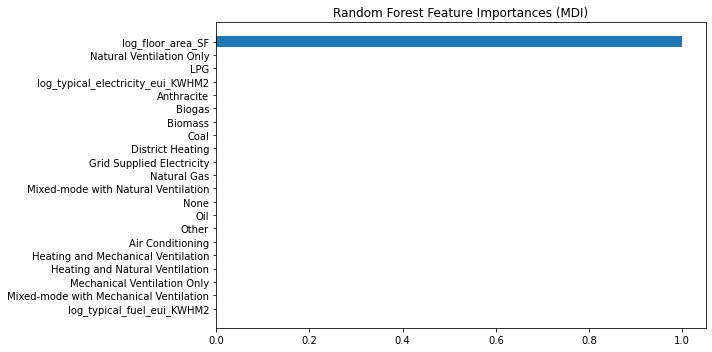

In [ ]:
#London
london_feature_names = np.concatenate([london_features.drop(['heating_fuel_type', 'hvac_type', 'typical_fuel_eui_KWHM2',
        'typical_electricity_eui_KWHM2', 'floor_area_SF'], axis=1).columns.values,
np.concatenate(london_enc.categories_)])
print(len(london_feature_names))

# Plot London
london_tree_feature_importances = (london_rf.feature_importances_)
london_sorted_idx = london_tree_feature_importances.argsort()

london_y_ticks = np.arange(0, len(london_feature_names))
fig, ax = plt.subplots(figsize=(10,5))
ax.barh(london_y_ticks, london_tree_feature_importances[london_sorted_idx])
ax.set_yticklabels(london_feature_names[london_sorted_idx])
ax.set_yticks(london_y_ticks)
ax.set_title("Random Forest Feature Importances (MDI)")
fig.tight_layout()
plt.show()

**Fig 1. London's Random Forest Feature Importance (MDI)** The figure above shows the random forest feature importance conducted by Random Forest Regressor model (max depth is 2, and random state is 0). As a result of the model, log floor area is the most important feature. It is similar to the result of this article in that Roth et al.(2020)'s result shows the total area is the most important feature. 

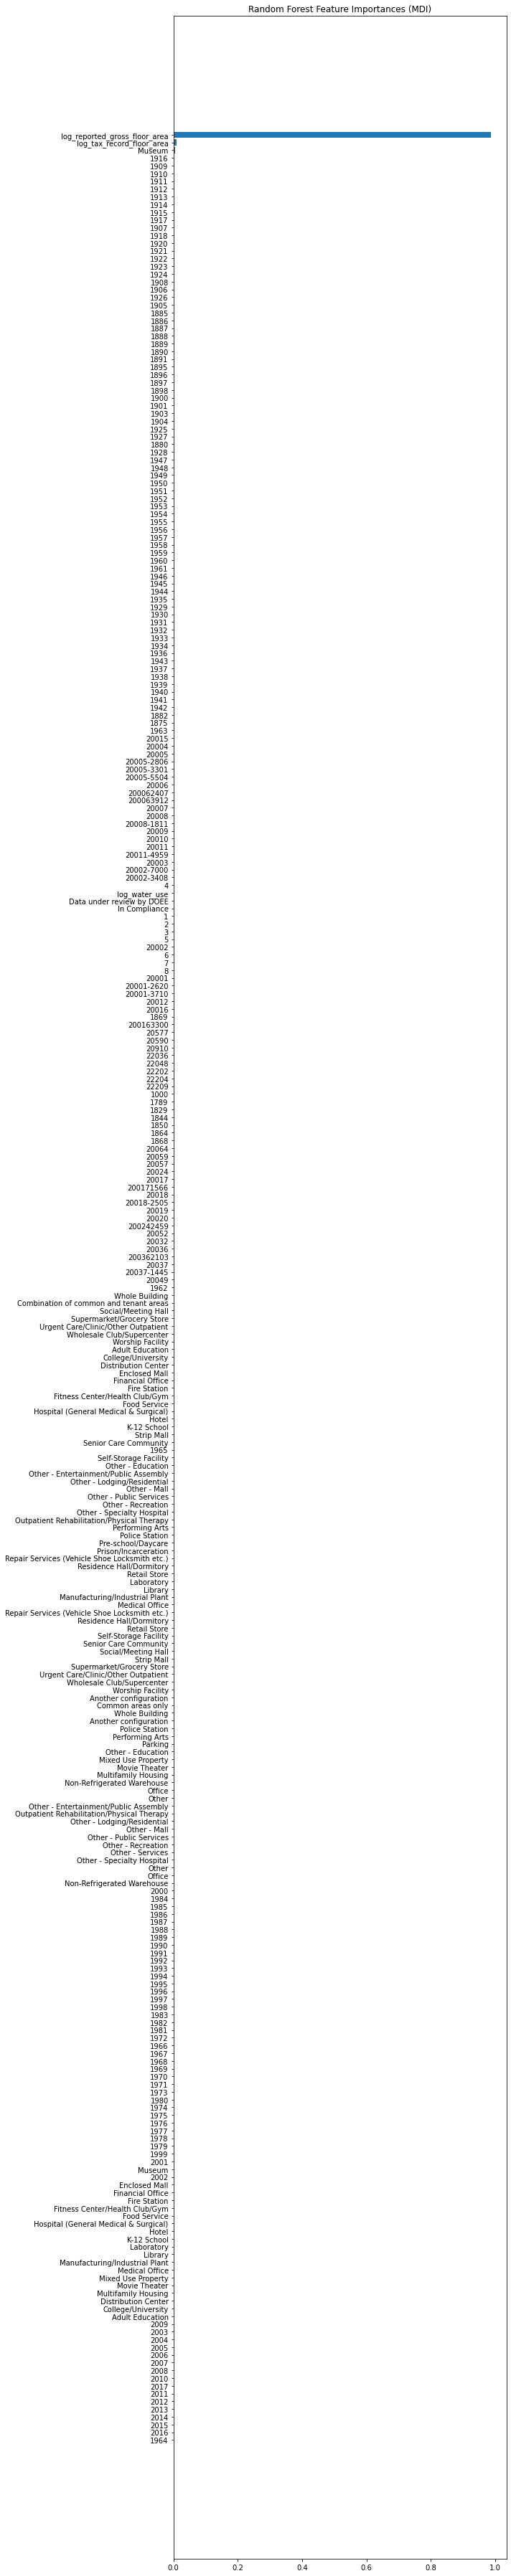

In [ ]:
# DC

# Set feature names
DC_feature_names = np.concatenate([DC_features.drop(["report_status", "primary_ptype_self", "primary_ptype_epa", 
               "metered_areas_energy", "metered_areas_water", "ward","postal_code",
               "year_built", "tax_record_floor_area", "reported_gross_floor_area", "water_use", 
               ], axis=1).columns.values,np.concatenate(DC_enc.categories_)])
len(DC_feature_names)

# Plot
DC_tree_feature_importances = (DC_rf.feature_importances_)
DC_sorted_idx = DC_tree_feature_importances.argsort()

DC_y_ticks = np.arange(0, len(DC_feature_names))
fig, ax = plt.subplots(figsize=(10,50))
ax.barh(DC_y_ticks, DC_tree_feature_importances[DC_sorted_idx])
ax.set_yticklabels(DC_feature_names[DC_sorted_idx])
ax.set_yticks(DC_y_ticks)
ax.set_title("Random Forest Feature Importances (MDI)")
fig.tight_layout()
plt.show()

**Fig 2. Washington DC's Random Forest Feature Importance (MDI)** The figure above shows the random forest feature importance conducted by Random Forest Regressor model (max depth is 2, and random state is 0). As a result of the model, log reported floor area is the most important feature and log tax flood area is the second most important feature. It is similar to the result of this article in that Roth et al.(2020)'s result shows the total area is the most important feature. 

# useful links and methods and functions I used: 

```df.dropna()``` to remove observation with missing variables

```df.drop(columns, axis=1)``` to remove features (columns)


```np.log10()``` and ```np.isinf()``` to convert to log space and find infinite values  


one hot encoder https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html and https://stackabuse.com/one-hot-encoding-in-python-with-pandas-and-scikit-learn/


KNN imputer https://scikit-learn.org/stable/modules/generated/sklearn.impute.KNNImputer.html , https://www.analyticsvidhya.com/blog/2020/07/knnimputer-a-robust-way-to-impute-missing-values-using-scikit-learn/, and 
https://machinelearningmastery.com/knn-imputation-for-missing-values-in-machine-learning/  

# FBB pretty good but the comments are few and far between! importantly you split your data between training and test but forgot to discuss if the model was overfitting